In [ ]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -U -q datasets fsspec huggingface_hub # Hugging Face's dataset library
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install transformers datasets scikit-learn pandas numpy matplotlib seaborn accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

# Structure

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


#### Path

In [ ]:
# Define root project folder
project_root = "/content/drive/Colab 266"

# Define subdirectories
data_dir = f"{project_root}/data/full_dataset"
output_dir = f"{project_root}/outputs"
model_dir = f"{project_root}/models/roberta_baseline"


####Create Folders

In [ ]:
import os

os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)


OSError: [Errno 95] Operation not supported: '/content/drive/Colab 266'

#### Load from TSVs

In [ ]:
import os
import pandas as pd

# Set folder path
folder_path = "/content/drive/MyDrive/Colab 266"

# Load each file
train_df = pd.read_csv(f"{folder_path}/train.tsv", sep="\t", header=None, names=["text", "labels", "id"])
test_df = pd.read_csv(f"{folder_path}/test.tsv", sep="\t", header=None, names=["text", "labels", "id"])
dev_df = pd.read_csv(f"{folder_path}/dev.tsv", sep="\t", header=None, names=["text", "labels", "id"])

emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

# Convert string label lists into real Python lists
for df in [train_df, test_df, dev_df]:
    df["labels"] = df["labels"].apply(lambda x: list(map(int, x.split(","))) if isinstance(x, str) else [])

# Extract primary label (first label in the list)
for df in [train_df, test_df, dev_df]:
    df["primary_label_id"] = df["labels"].apply(lambda x: x[0] if len(x) > 0 else -1)  # -1 as placeholder

# Map label IDs to emotion names
for df in [train_df, test_df, dev_df]:
    df["primary_label_name"] = df["primary_label_id"].apply(lambda idx: emotion_labels[idx] if idx >= 0 else "unknown")

# Optional: preview the cleaned datasets
print(train_df[["text", "labels", "primary_label_id", "primary_label_name"]].head())


                                                text labels  primary_label_id  \
0  My favourite food is anything I didn't have to...   [27]                27   
1  Now if he does off himself, everyone will thin...   [27]                27   
2                     WHY THE FUCK IS BAYLESS ISOING    [2]                 2   
3                        To make her feel threatened   [14]                14   
4                             Dirty Southern Wankers    [3]                 3   

  primary_label_name  
0            neutral  
1            neutral  
2              anger  
3               fear  
4          annoyance  


#### Convert Multi-Label → Single Label

In [ ]:
# Keep only the first label from the multi-label list (e.g., '[9, 16]' → 9)
for df in [train_df, test_df, dev_df]:
    df["primary_label"] = df["labels"].apply(lambda x: int(str(x).strip("[]").split(",")[0]))


####  Map Label ID → Emotion Name

In [ ]:
for df in [train_df, test_df, dev_df]:
    df["emotion"] = df["primary_label"].apply(lambda x: emotion_labels[x])



 ### Save to CSV

In [ ]:
train_df.to_csv(f"{folder_path}/train_primary_label.csv", index=False)
test_df.to_csv(f"{folder_path}/test_primary_label.csv", index=False)
dev_df.to_csv(f"{folder_path}/dev_primary_label.csv", index=False)


In [ ]:
!pip install datasets transformers

#### Save the Cleaned Dataset

In [ ]:
!pip install transformers datasets scikit-learn


 #### Load Your Preprocessed Data

#### Tokenization + HF Dataset Conversion

In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=64)

# Convert DataFrames to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df)
dev_ds = Dataset.from_pandas(dev_df)
test_ds = Dataset.from_pandas(test_df)

# Tokenize datasets
train_ds = train_ds.map(tokenize, batched=True)
dev_ds = dev_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

# Fix: remove existing 'labels' column if present
for name, ds in zip(["train", "dev", "test"], [train_ds, dev_ds, test_ds]):
    if "labels" in ds.column_names:
        ds = ds.remove_columns("labels")
    ds = ds.rename_column("primary_label", "labels").with_format("torch")
    if name == "train":
        train_ds = ds
    elif name == "dev":
        dev_ds = ds
    else:
        test_ds = ds

print("Tokenization + Dataset formatting complete!")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Tokenization + Dataset formatting complete!


#### Define TrainingArguments & Evaluation Metric

#### Define compute_metrics Function

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


##### Initialize Your Model

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(emotion_labels)  # should match your label count (likely 28)
)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Create the Trainer & Start Training

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/emotion-project/roberta_checkpoints",
    run_name="roberta_goemotions",
    eval_strategy="epoch",                    # updated key name
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,1.491900,1.457862,0.553262
2,1.249700,1.365097,0.572982
3,0.984800,1.399962,0.576484
4,0.782300,1.492160,0.572245


TrainOutput(global_step=10856, training_loss=1.1933516106714461, metrics={'train_runtime': 2319.1047, 'train_samples_per_second': 74.874, 'train_steps_per_second': 4.681, 'total_flos': 5712158611722240.0, 'train_loss': 1.1933516106714461, 'epoch': 4.0})

#### Save Everything After Training

In [ ]:
BEST_DIR = "/content/drive/MyDrive/emotion-project/roberta_tsv_best"

trainer.save_model(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)


('/content/drive/MyDrive/emotion-project/roberta_tsv_best/tokenizer_config.json',
 '/content/drive/MyDrive/emotion-project/roberta_tsv_best/special_tokens_map.json',
 '/content/drive/MyDrive/emotion-project/roberta_tsv_best/vocab.json',
 '/content/drive/MyDrive/emotion-project/roberta_tsv_best/merges.txt',
 '/content/drive/MyDrive/emotion-project/roberta_tsv_best/added_tokens.json',
 '/content/drive/MyDrive/emotion-project/roberta_tsv_best/tokenizer.json')

#### Load Predictions and Create Classification Report

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 1: Get predictions
preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Step 2: Load label names (should already be defined)
# Example fallback:
# emotion_labels = ['admiration', 'amusement', ..., 'neutral']

# Step 3: Generate classification report with zero_division fix
report = classification_report(
    y_true,
    y_pred,
    target_names=emotion_labels,
    output_dict=True,
    zero_division=0  # prevents NaN for zero predicted labels
)

# Step 4: Convert to DataFrame
df_report = pd.DataFrame(report).transpose().round(3)

# Step 5: Keep only emotions (drop avg, accuracy, etc.)
df_emotions = df_report.iloc[:len(emotion_labels)][["precision", "recall", "f1-score"]]
df_emotions = df_emotions.reset_index().rename(columns={"index": "Emotion", "f1-score": "F1"})

# Optional: sort by F1
df_emotions = df_emotions.sort_values("F1", ascending=False)

# Step 6: Save to CSV
output_path = "/content/drive/MyDrive/emotion-project/roberta_tsv_best/emotion_classification_report.csv"
df_emotions.to_csv(output_path, index=False)
print(f"Saved classification report to: {output_path}")



Saved classification report to: /content/drive/MyDrive/emotion-project/roberta_tsv_best/emotion_classification_report.csv


In [ ]:
print(df_report)

                precision  recall  f1-score   support
admiration          0.655   0.748     0.698   504.000
amusement           0.727   0.909     0.808   252.000
anger               0.556   0.426     0.483   197.000
annoyance           0.357   0.287     0.318   286.000
approval            0.496   0.393     0.439   318.000
caring              0.349   0.395     0.370   114.000
confusion           0.347   0.475     0.401   139.000
curiosity           0.445   0.588     0.506   233.000
desire              0.603   0.473     0.530    74.000
disappointment      0.385   0.315     0.346   127.000
disapproval         0.359   0.427     0.390   220.000
disgust             0.463   0.452     0.458    84.000
embarrassment       0.667   0.467     0.549    30.000
excitement          0.357   0.417     0.385    84.000
fear                0.627   0.703     0.662    74.000
gratitude           0.855   0.816     0.835   288.000
grief               0.000   0.000     0.000     6.000
joy                 0.500   

In [ ]:
# Save cleaned per-emotion metrics table
df_emotions.to_csv(f"{BEST_DIR}/emotion_classification_report.csv", index=False)


#### F1 Score by Emotion

/tmp/ipython-input-20-3951767921.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_emotions, x="f1-score", y="Emotion", palette="coolwarm")


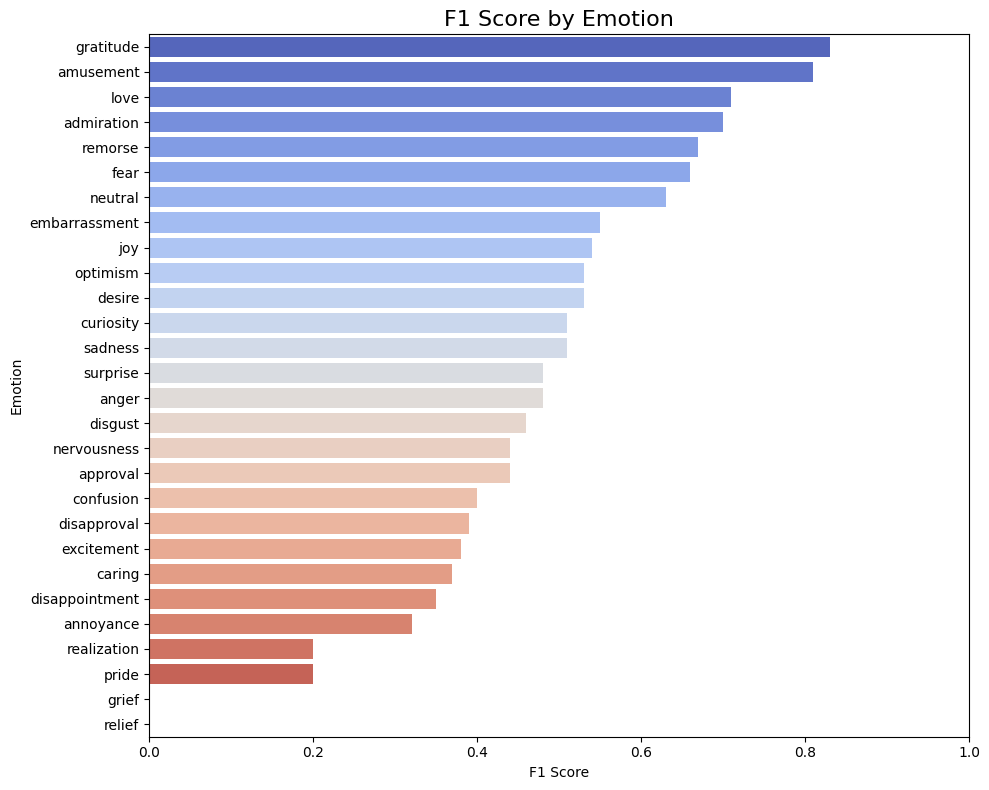

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(f"{BEST_DIR}/emotion_classification_report.csv")
df = df.rename(columns={"Unnamed: 0": "Emotion"})
df_emotions = df[~df["Emotion"].str.contains("avg|accuracy", case=False, na=False)].copy()
df_emotions = df_emotions.sort_values("f1-score", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_emotions, x="f1-score", y="Emotion", palette="coolwarm")
plt.title("F1 Score by Emotion", fontsize=16)
plt.xlabel("F1 Score")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/figure_1_f1_scores.pdf")
plt.savefig(f"{BEST_DIR}/figure_1_f1_scores.png")
plt.show()


#### Figure 2: Grouped Bar Chart (Precision, Recall, F1)

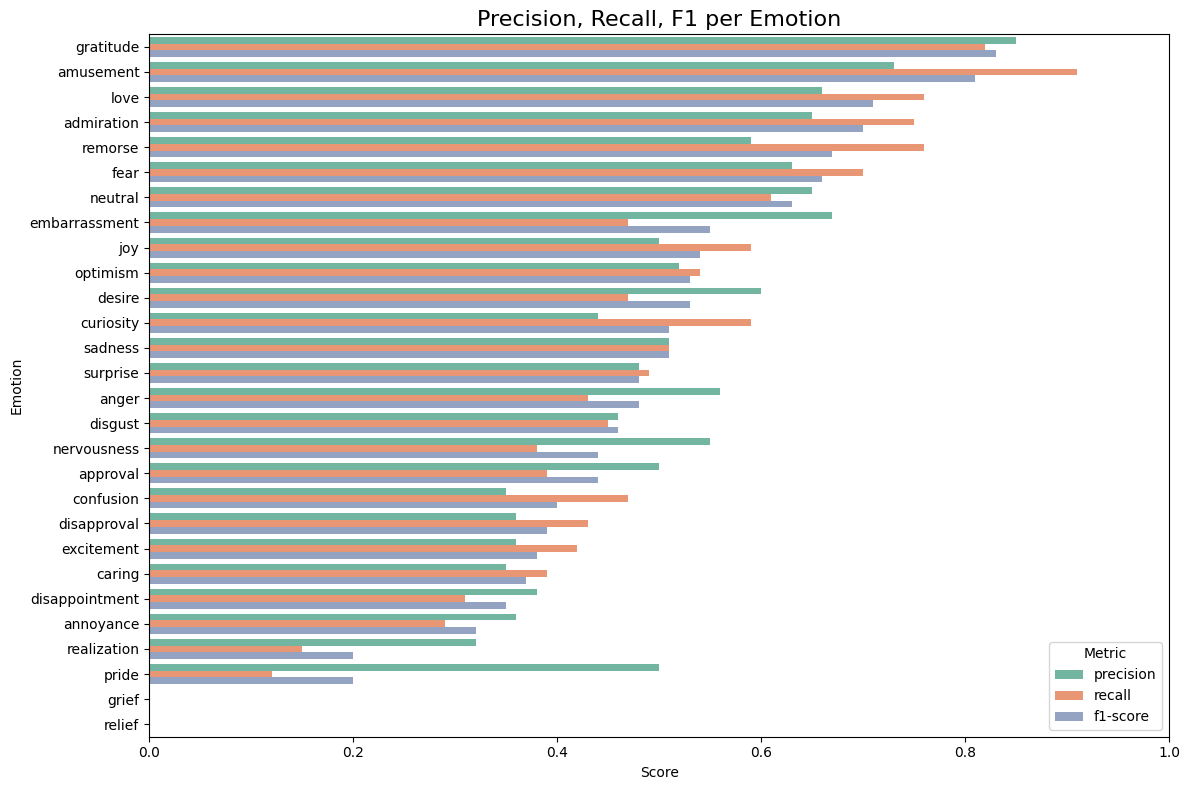

In [ ]:
df_metrics = df_emotions[["Emotion", "precision", "recall", "f1-score"]]
df_melted = df_metrics.melt(id_vars="Emotion", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, x="Score", y="Emotion", hue="Metric", palette="Set2")
plt.title("Precision, Recall, F1 per Emotion", fontsize=16)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/figure_2_grouped_metrics.pdf")
plt.savefig(f"{BEST_DIR}/figure_2_grouped_metrics.png")
plt.show()


#### Macro-Averaged Scores

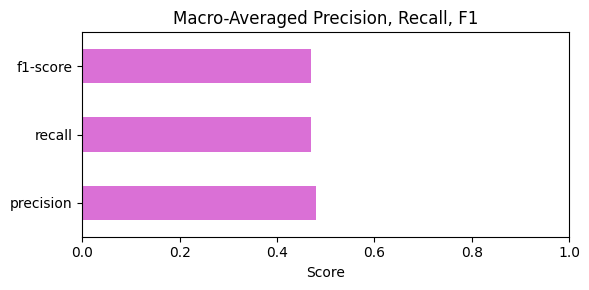

In [ ]:
macro_scores = df[df["Emotion"] == "macro avg"][["precision", "recall", "f1-score"]].T
macro_scores.columns = ["Macro Avg"]

macro_scores.plot(kind="barh", legend=False, figsize=(6, 3), color="orchid")
plt.title("Macro-Averaged Precision, Recall, F1")
plt.xlabel("Score")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/figure_3_macro_averages.pdf")
plt.savefig(f"{BEST_DIR}/figure_3_macro_averages.png")
plt.show()


#### Confusion Matrix

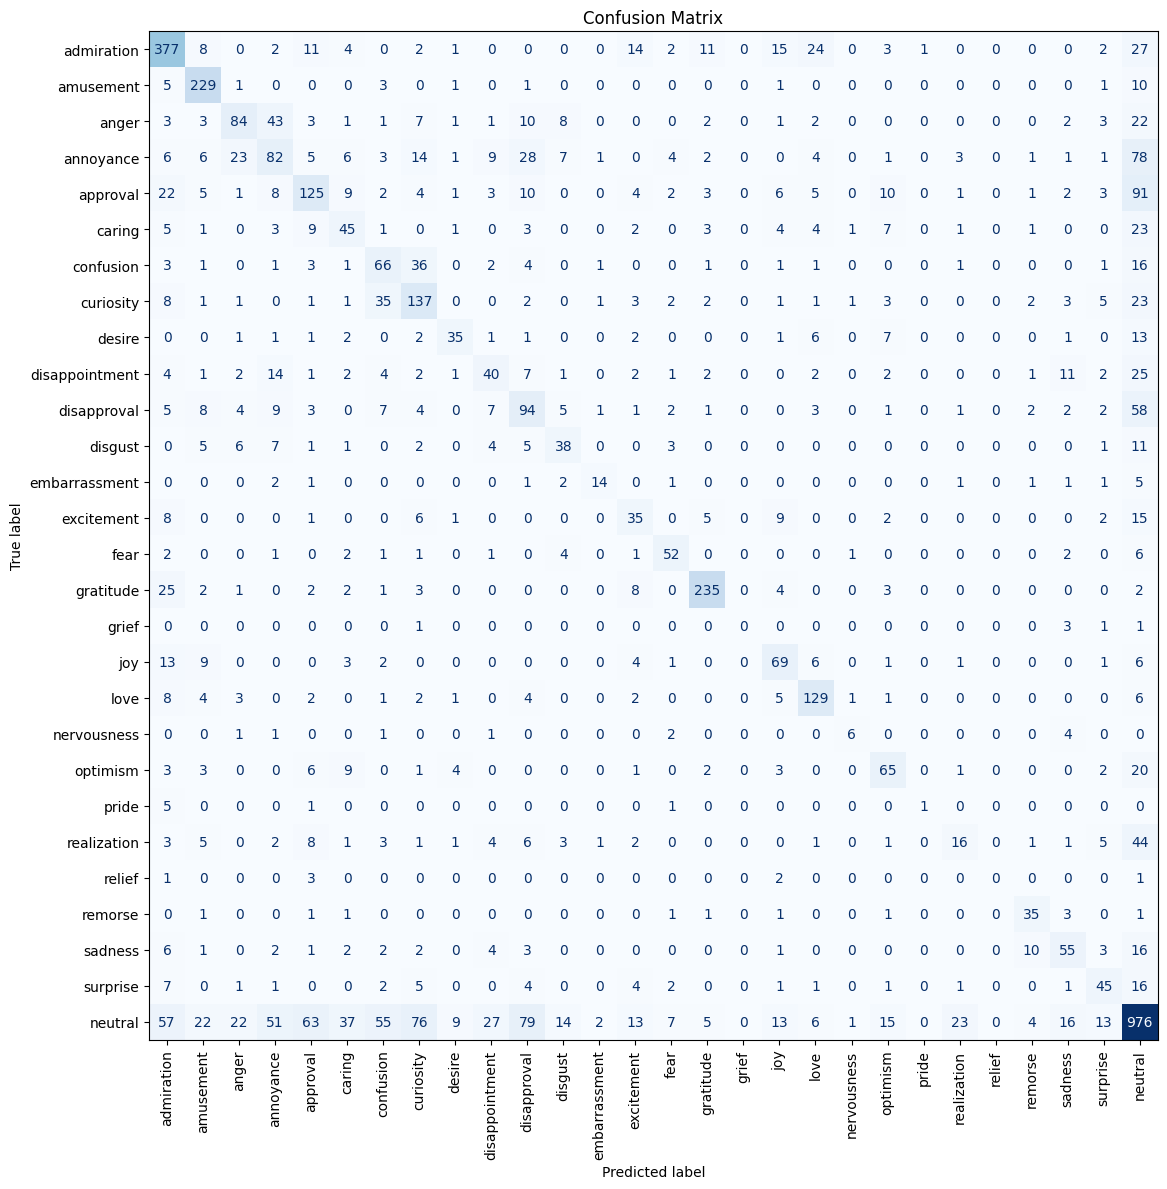

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/figure_4_confusion_matrix.pdf")
plt.savefig(f"{BEST_DIR}/figure_4_confusion_matrix.png")
plt.show()


#### Support (Sample Count) per Emotion

/tmp/ipython-input-24-472531928.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_support, x="support", y="Emotion", palette="crest")


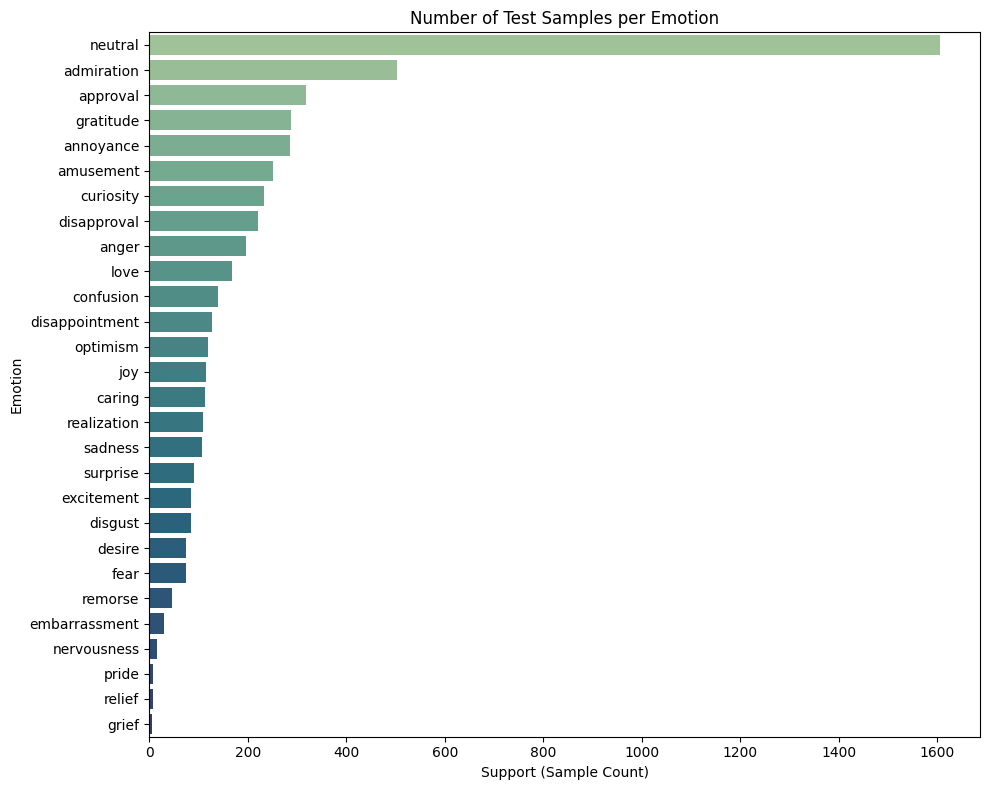

In [ ]:
df_support = df_emotions[["Emotion", "support"]].sort_values("support", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_support, x="support", y="Emotion", palette="crest")
plt.title("Number of Test Samples per Emotion")
plt.xlabel("Support (Sample Count)")
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/figure_5_support_counts.pdf")
plt.savefig(f"{BEST_DIR}/figure_5_support_counts.png")
plt.show()
